# Sample Code

## 基礎建設

In [62]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [63]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-26 14:18:15--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.1’

All_Beauty.csv.1    100%[===================>]  14.78M  24.6MB/s    in 0.6s    

2021-12-26 14:18:15 (24.6 MB/s) - ‘All_Beauty.csv.1’ saved [15499476/15499476]

--2021-12-26 14:18:16--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.1’

meta_All_Beauty.jso 100%[===================>]   9.85M  18.6MB/s    in 0.5s   

In [64]:
#商品的基本資訊 metadata,購買商品的紀錄 ratings
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

## 資料整理

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [67]:
no_ratings = ratings[['reviewerID','asin']].groupby("reviewerID").count().sort_values(by=['asin'], ascending=False).reset_index()
no_ratings

,reviewerID,asin
0,A2GJX2KCUSR0EI,27
1,A1KSC91G9AIY2Z,23
2,A22CW0ZHY3NJH8,21
3,A1EGCED01USBA9,21
4,AENH50GW3OKDA,20
...,...,...
324033,A2BZ7MYTSNYMEW,1
324034,A2BZ6YMTPARCXV,1
324035,A2BZ6FH245B7AV,1
324036,A2BZ5TE4U5DI01,1


In [68]:
# 商品資訊-只留下要求的欄位
purchase_df = metadata[['asin', 'brand', 'title', 'price', 'rank']]

In [69]:
#商品資訊-買什麼種類
purchase_df['categories'] = purchase_df['rank'].str.split(expand = True).loc[:, 2:5].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [70]:
# 取出字串前段數字,取代掉千分位
purchase_df['rank'] = purchase_df['rank'].str.split(expand = True)[0].str.replace(',', '')
#轉換型別
purchase_df['rank'] = pd.to_numeric(purchase_df['rank'])

In [74]:
purchase_df.head(5)

,asin,brand,title,price,rank,categories
0,6546546450,idea village,Loud 'N Clear&trade; Personal Sound Amplifier,,2938573.0,Beauty&PersonalCare
1,7178680776,,No7 Lift &amp; Luminate Triple Action Serum 50...,$44.99,872854.0,Beauty&PersonalCare
2,7250468162,No7,No7 Stay Perfect Foundation Cool Vanilla by No7,$28.76,956696.0,Beauty&PersonalCare
3,7367905066,,Wella Koleston Perfect Hair Colour 44/44 Mediu...,,1870258.0,Beauty&PersonalCare
4,7414204790,Pirmal Healthcare,Lacto Calamine Skin Balance Oil control 120 ml...,$12.15,67701.0,Beauty&PersonalCare


In [75]:
ratings.shape

(371345, 5)

In [149]:
purchase_category_df = purchase_df[['asin','categories']].drop_duplicates(subset=['asin','categories'])

In [155]:
ratings = pd.merge(ratings, purchase_category_df, on="asin", how="left").fillna("unknown")

# 資料描繪

In [79]:
pip install surprise

In [80]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [81]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

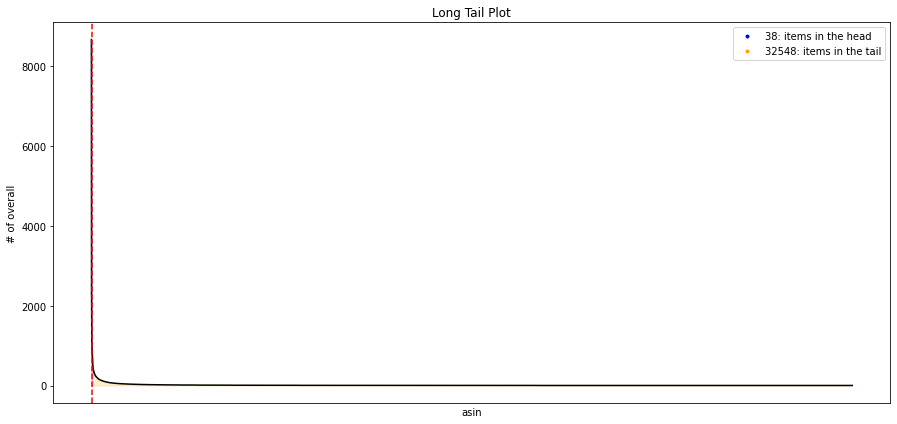

In [82]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,7))
long_tail_plot(df= ratings,
                         item_id_column='asin',
                         interaction_type='overall',
                         percentage=0.2,
                         x_labels=False)

In [83]:
 def longtail_head_asin(df, item_id_column, percentage=None):
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    if percentage != None:
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = list(head['asin'].unique())
        #items_in_tail = list(tail['asin'].unique())
    return items_in_head

In [84]:
head_asin = longtail_head_asin(df= ratings,
                         item_id_column='asin',
                         percentage=0.2)

## 資料切分

In [156]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]

In [157]:
ratings

,asin,reviewerID,overall,unixReviewTime,DATE,categories
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000,2015-02-19,unknown
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800,2014-12-18,unknown
2,0143026860,A1572GUYS7DGSR,4.0,1407628800,2014-08-10,unknown
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000,2013-03-11,unknown
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200,2011-12-25,unknown
...,...,...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800,2017-07-20,Beauty&PersonalCare
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400,2017-03-16,Beauty&PersonalCare
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400,2017-03-01,Beauty&PersonalCare
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200,2017-02-21,Beauty&PersonalCare


In [144]:
#group by 用戶ID {'asin': ['B017JBTB98'], 'reviewerID': 'ACCY5NWUNEC87'}
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')

#換格式 {'A12M4U7WK4ALCR': ['B01DKQAXC0']}
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
#所有用戶 'ATR9J7TYR1KVL'
users = list(ratings_testings_by_user.keys())

In [159]:
user_category = ratings_trainings[ratings_trainings['categories'] != "unknown"].groupby(by=['reviewerID','categories']).size().reset_index()
user_category.columns = ["user", "categories","volumn"]
grouped_df = user_category.groupby("user")
user_category_max = grouped_df.max()
user_category_max = user_category_max.reset_index()

,user,categories,volumn
0,A0010876CNE3ILIM9HV0,Beauty&PersonalCare,1
1,A001170867ZBE9FORRQL,nannannannan,1
2,A0028738FYF1SKPPC7B1,Beauty&PersonalCare,1
3,A0045356A23634W7RI4M,Beauty&PersonalCare,1
4,A006277084SDH2LTUV6X,Beauty&PersonalCare,1
...,...,...,...
318781,AZZW8CF93X1TC,Beauty&PersonalCare,1
318782,AZZWNU4RB5BY1,Beauty&PersonalCare,1
318783,AZZXKG9AGRVGU,Beauty&PersonalCare,1
318784,AZZYW4YOE1B6E,Beauty&PersonalCare,1


In [ ]:
pd.merge(user_category_max[['user', 'categories']],customer,on='Product_ID',how='outer')

,user,categories
0,A0010876CNE3ILIM9HV0,Beauty&PersonalCare
1,A001170867ZBE9FORRQL,nannannannan
2,A0028738FYF1SKPPC7B1,Beauty&PersonalCare
3,A0045356A23634W7RI4M,Beauty&PersonalCare
4,A006277084SDH2LTUV6X,Beauty&PersonalCare
...,...,...
318781,AZZW8CF93X1TC,Beauty&PersonalCare
318782,AZZWNU4RB5BY1,Beauty&PersonalCare
318783,AZZXKG9AGRVGU,Beauty&PersonalCare
318784,AZZYW4YOE1B6E,Beauty&PersonalCare


## 產生推薦

In [160]:
from random import sample

In [115]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    ratings_trainings = training_data
    #排除熱銷商品
    new_list = []
    for i in set(ratings_trainings['asin']):
      if i not in head_asin:
        new_list.append(i)
    #推薦使用者最常使用的類別asin
    user_category_max
    

    recommendations = {user: sample(new_list,k) for user in users}
    return recommendations

In [111]:
#ratings_trainings[ratings_trainings['asin'] == 'B001QY8QXM']

In [163]:
    new_list = []
    for i in set(ratings_trainings['asin']):
      if i not in head_asin:
        new_list.append(i)

In [164]:
new_list


['B0016JFHFC',
 'B00ZTFRZ9K',
 'B00028EYZW',
 'B01EGW8L4O',
 'B00YWB1YSA',
 'B01E9YZG5Q',
 'B003R66K26',
 'B00HNMSSJI',
 'B00YANACTW',
 'B005LDE1JM',
 'B00RW5XL2A',
 'B00TJ5EPSK',
 'B00W3LA09U',
 'B00K7GWNAC',
 'B01E3VADVW',
 'B018SU48UQ',
 'B019DJR9L6',
 'B00RJM9UYY',
 'B0117Z41Y2',
 'B00NZIN006',
 'B00OP9FKWA',
 'B00YQCN9WO',
 'B01EC2P6RS',
 'B01DABSQVK',
 'B01EN0FICW',
 'B001F51QXO',
 'B01DZPSQV6',
 'B001B7O1OC',
 'B00SHVGGH0',
 'B00JAT37FC',
 'B00NB0QWX0',
 'B00MK92IJ0',
 'B01CDCUJPI',
 'B00S4CNW9C',
 'B017NFTMBW',
 'B002C6G9MI',
 'B0127QOIJI',
 'B00ILHMVAG',
 'B0146X3W8I',
 'B010NJGBZU',
 'B017NYVDF6',
 'B00HNISOMI',
 'B01BHO3RLG',
 'B00GRA9T4A',
 'B00I6M6RRE',
 'B00IRLYOGK',
 'B017CGN9G6',
 'B00SCIKPL6',
 'B00HY5BS7S',
 'B002DXVK88',
 'B00M0W8G5C',
 'B010TDPR2I',
 'B00VJ4H4KA',
 'B012EA2BEQ',
 'B000NSZ4SW',
 'B009X1X8OM',
 'B00JHU2THQ',
 'B008E0DBYA',
 'B01066SSW4',
 'B00006VIKS',
 'B00H4T5J56',
 'B00LPD1OUQ',
 'B00MUBZODA',
 'B004WU00MM',
 'B00G4EOZZ2',
 'B007Y4EFWE',
 'B00JY2U3

In [116]:
ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

{'A100XQFWKQ30O2': ['B00IAA0EO4',
  'B018J1TGK6',
  'B00SQNHMTK',
  'B00K1Y0T5G',
  'B00P6TZ86G',
  'B00LG2GECE',
  'B00QMTXSU2',
  'B001JQLNVO',
  'B00M5I8HZ0',
  'B00PNNCTLC'],
 'A103T1QOGFCSEH': ['B014CCCZLI',
  'B0060PA7A2',
  'B017NA063A',
  'B001S0ILU2',
  'B017A89SX4',
  'B00DTPZ88M',
  'B0013NHR90',
  'B0053D6AGM',
  'B00E4J2C6I',
  'B00IA6WI8I'],
 'A106UKKSJ2KXPF': ['B00K3PL6M8',
  'B000981E76',
  'B00EF1EFW4',
  'B00ZNDN4MA',
  'B01B8FQW1Q',
  'B00JKPL208',
  'B00NB0QIIO',
  'B00AVSR3ME',
  'B001F51W8S',
  'B001DESQ2Q'],
 'A10A7GV4D5A11V': ['B001KA74JY',
  'B01H241G6S',
  'B00BCAQVSC',
  'B00HFOP80Q',
  'B01GIFAALE',
  'B00IBOM2Z8',
  'B0172MP3XW',
  'B01A9B1GNE',
  'B00157BTMU',
  'B00YIQI5RW'],
 'A1119JJ37ZLB8R': ['B01BKYR0P2',
  'B003O4AP40',
  'B015KEUP8W',
  'B00U2GUFIY',
  'B00MF2KNAI',
  'B006VY48RK',
  'B01F8LGJH8',
  'B000065AB1',
  'B01DA0J0U2',
  'B00NVSOVM6'],
 'A113UOOLBSZN52': ['B00BPPOM8K',
  'B01C3K0S0Q',
  'B002ZWV3EI',
  'B0041MP9O0',
  'B00YWMILYO',
  'B00Y

## 結果評估

In [118]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0